In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import altair as alt
from datetime import datetime

from plotting import *

In [67]:
df = (
    pd.read_csv('timeseries.csv')
    .loc[lambda d: d['series'] == 'summer_1'][['t', 'value']]
    .assign(
        value=lambda d: d['value'] / d['value'].max(),
        date=lambda d: pd.to_datetime(d['t']),
        t=lambda d: np.arange(len(d)) / len(d)
    )
)
df.head()

,t,value,date
0,0.000,0.560490,2018-01-01
2,0.001,0.557879,2018-01-02
4,0.002,0.573554,2018-01-03
6,0.003,0.578706,2018-01-04
8,0.004,0.528408,2018-01-05


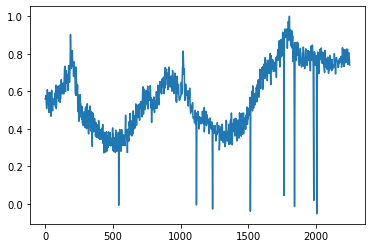

In [5]:
import matplotlib.pyplot as plt
plt.plot(df['value'])

In [55]:
import pymc3 as pm
import theano.tensor as tt


n_changepoints = 10
t = np.arange(len(df)) / len(df)
s = np.linspace(0, max(t), n_changepoints + 2)[1: -1]
A = (t[:, None] > s) * 1.

n_components = 3

def X(t, p=365.25, n=3):
    x = 2 * np.pi * (np.arange(n) + 1) * t[:, None] / p
    return np.concatenate((np.cos(x), np.sin(x)), axis=1)

In [61]:
with pm.Model() as model:
    
    k = pm.Normal('k', 0, 1)
    m = pm.Normal('m', 0, 5)
    delta = pm.Laplace('delta', 0, 0.1, shape=n_changepoints)
    
    growth = k + tt.dot(A, delta)
    offset = m + tt.dot(A, -s * delta)
    trend = growth * t + offset
    
    beta = pm.Normal('beta', 0, 1, shape=n_components * 2)
    seasonality = tt.dot(X(t, 365.25/len(t)), beta)
    
    prediction = trend + seasonality
    error = pm.HalfCauchy('sigma', 0.5)
    pm.Normal(
        'obs',
        prediction,
        error,
        observed=df['value']
    )
    
    trace = pm.sample(tune=1000, cores=6, chains=6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [sigma, beta, delta, m, k]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [01:33<00:00, 95.77draws/s] 
The acceptance probability does not match the target. It is 0.8869375364156955, but should be close to 0.8. Try to increase the number of tuning steps.


In [62]:
trend_df, plot_s = trend_component(t, np.mean(trace['delta'], axis=0), np.mean(trace['k']), np.mean(trace['m']), s)
plot_trend(df, trend_df, plot_s)

alt.VConcatChart(...)

In [65]:
seasonal_df = seasonal_components(t, np.mean(trace['beta'], axis=0))
plot_seasonal_components(df, seasonal_df)

alt.LayerChart(...)

In [66]:
plot_all(df, trend_df, seasonal_df)

alt.LayerChart(...)

In [103]:
def get_group_definition(X, pool_cols, pool_type='complete'):
    if pool_type == 'complete':
        group = np.zeros(len(X), dtype='int')
        group_mapping = {0: 'all'}
        n_groups = 1
    else:
        group = X[pool_cols].cat.codes.values
        group_mapping = dict(enumerate(X[pool_cols].cat.categories))
        n_groups = X[pool_cols].nunique()
    return group, n_groups


In [113]:
class TimeSeriesModel:
    def fit(self, X, y, **sample_kwargs):
        self.model = pm.Model()
        prediction = self.definition(self.model, X, y)
        
        with self.model:
            error = pm.HalfCauchy('error', 0.5)
            pm.Normal(
                'obs',
                mu=prediction,
                sigma=error,
                observed=y
            )
            self.trace = pm.sample(tune=1000, cores=6, chains=6, **sample_kwargs)
    
    def __add__(self, other):
        return AdditiveTimeSeries(self, other)
            
    def __mul__(self, other):
        return MultiplicativeTimeSeries(self, other)
    
    
class AdditiveTimeSeries(TimeSeriesModel):
    def __init__(self, l, r):
        self.l = l
        self.r = r
        
    def definition(self, model, X, y):
        return self.l.definition(model, X, y) + self.r.definition(model, X, y)
    
       
class MultiplicativeTimeSeries(TimeSeriesModel):
    def __init__(self, l, r):
        self.l = l
        self.r = r
        
    def definition(self, model, X, y):
        return self.l.definition(model, X, y) * self.r.definition(model, X, y) 
    

class LinearTrend(TimeSeriesModel):
    def __init__(self, n_changepoints, pool_cols=None, pool_type='complete'):
        self.n_changepoints = n_changepoints
        self.pool_cols = pool_cols
        self.pool_type = pool_type
    
    def definition(self, model, X, y):
        t = X['t']
        group, n_groups, _ = get_group_definition(X, self.pool_cols, self.pool_type)
        
        s = np.linspace(0, np.max(t), self.n_changepoints + 2)[1:-1]
        A = (t[:, None] > s) * 1.
        
        with pm.Model(f'LinearTrend({self.n_changepoints})', model):
            if self.pool_type == 'partial':
                sigma_k = pm.HalfCauchy('sigma_k', 1)
                offset_k = pm.Normal('offset_k', 0, 1, shape=n_groups)
                k = pm.Deterministic('k', sigma_k * offset_k)
                
                sigma_m = pm.HalfCauchy('sigma_m', 5)
                offset_m = pm.Normal('offset_m', 0, 1, shape=n_groups)
                m = pm.Deterministic('m', sigma_m * offset_m)
                
                sigma_delta = pm.HalfCauchy('sigma_delta', 0.1)
                offset_delta = pm.Normal('offset_delta', 0, 1, shape=(n_groups, n_changepoints))
                delta = pm.Deterministic('delta', sigma_delta * offset_delta)
                
            else:
                k = pm.Normal('k', 0, 1, shape=n_groups)
                m = pm.Normal('m', 0, 5, shape=n_groups)
                delta = pm.Laplace('delta', 0, 0.1, shape=(n_groups, self.n_changepoints))

            growth = k[group] + pm.math.sum(A * delta[group, :], axis=1)
            offset = m[group] + pm.math.sum(A * -s * delta[group, :], axis=1)
            trend = growth * t + offset
        
        return trend
        
        
    
class FourierSeasonality(TimeSeriesModel):
    def __init__(self, n, p, pool_cols=None, pool_type='complete'):
        self.n = n
        self.p = p
        self.pool_cols = pool_cols
        self.pool_type = pool_type
        
    def _X(self, t, p, n):
        x = 2 * np.pi * (np.arange(n) + 1) * t[:, None] / p
        return np.concatenate((np.cos(x), np.sin(x)), axis=1)
        
    def definition(self, model, X, y):
        t = X['t']
        group, n_groups, _ = get_group_definition(X, self.pool_cols, self.pool_type)
        
        with pm.Model(f'FourierSeasonality({self.n}, {self.p})', model):
            if self.pool_type == 'partial':
                mu_beta = pm.Normal('mu_beta', 0, 1, shape=self.n * 2)
                sigma_beta = pm.HalfNormal('sigma_beta', 0.1, shape=self.n * 2)
                offset_beta = pm.Normal('offset_beta', 0, 1, shape=(n_groups, self.n * 2))
                
                beta = pm.Deterministic('beta', mu_beta + offset_beta * sigma_beta)
                
            else:
                beta = pm.Normal('beta', 0, 1, shape=(n_groups, self.n * 2))
        
        seasonality = pm.math.sum(self._X(t, self.p / len(t), self.n) * beta[group], axis=1)
        
        return seasonality
        

In [ ]:
class TimeSeriesModel:
    def fit(self, X, y, **sample_kwargs):
        self.model = pm.Model()
        prediction = self.definition(self.model, X, y)
        
        with self.model:
            error = pm.HalfCauchy('error', 0.5)
            pm.Normal(
                'obs',
                mu=prediction,
                sigma=error,
                observed=y
            )
            self.trace = pm.sample(tune=1000, cores=6, chains=6, **sample_kwargs)
    
    def __add__(self, other):
        return AdditiveTimeSeries(self, other)
            
    def __mul__(self, other):
        return MultiplicativeTimeSeries(self, other)
    
    
class AdditiveTimeSeries(TimeSeriesModel):
    def __init__(self, l, r):
        self.l = l
        self.r = r
        
    def definition(self, model, X, y):
        return self.l.definition(model, X, y) + self.r.definition(model, X, y)
    
       
class MultiplicativeTimeSeries(TimeSeriesModel):
    def __init__(self, l, r):
        self.l = l
        self.r = r
        
    def definition(self, model, X, y):
        return self.l.definition(model, X, y) * self.r.definition(model, X, y) 
    

class LinearTrend(TimeSeriesModel):
    def __init__(self, n_changepoints, pool_cols=None, pool_type='complete'):
        self.n_changepoints = n_changepoints
        self.pool_cols = pool_cols
        self.pool_type = pool_type
    
    def definition(self, model, X, y):
        t = X['t']
        group, n_groups, _ = get_group_definition(X, self.pool_cols, self.pool_type)
        
        s = np.linspace(0, np.max(t), self.n_changepoints + 2)[1:-1]
        A = (t[:, None] > s) * 1.
        
        with model:
                k = pm.Normal('k', 0, 1, shape=n_groups)
                m = pm.Normal('m', 0, 5, shape=n_groups)
                delta = pm.Laplace('delta', 0, 0.1, shape=(n_groups, self.n_changepoints))

            growth = k[group] + pm.math.sum(A * delta[group, :], axis=1)
            offset = m[group] + pm.math.sum(A * -s * delta[group, :], axis=1)
            trend = growth * t + offset
        
        return trend
        
        
    
class FourierSeasonality(TimeSeriesModel):
    def __init__(self, n, p):
        self.n = n
        self.p = p
        
    def definition(self, model, X, y):
        t = X['t']
       
        with model
            beta = pm.Normal('beta', 0, 1, shape=self.n * 2)
            seasonality = pm.math.sum(X(t, self.p / len(t), self.n) * beta[group], axis=1)
        
        return seasonality
        

In [114]:
model = LinearTrend(n_changepoints=10) + FourierSeasonality(n=3, p=365.25) + FourierSeasonality(n=3, p=7)

In [115]:
model.fit(df[['t']], df['value'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [error, beta, delta, m, k]
Sampling 6 chains, 0 divergences: 100%|██████████| 9000/9000 [05:38<00:00, 26.57draws/s]
The acceptance probability does not match the target. It is 0.6836575543113229, but should be close to 0.8. Try to increase the number of tuning steps.
